In [90]:
#TODO: try out BERT and LDA for topic modelling, calculate out the metrics and compare the models

#LDA is unsupervised learning which doesnt require labeled data to train
#BERT is a pretrained model which is a supervised learning method, requires labeled data to train

#LDA can provide insights to the underlying pattern in the data, resulting topics are easily interpreted by humans
#BERT can provide more accurate results but requires labeled data and significant computation resources


In [91]:
#import preprocessed file and sentiment analysis


In [92]:
!pip install transformers

In [93]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
#from transformers import AutoModel

import gensim
from gensim.models import Phrases
#Prepare objects for LDA gensim implementation
from gensim import corpora
#Running LDA
from gensim import models

import matplotlib.pyplot as plt
import seaborn as sns

import gensim.corpora as corpora

from gensim.models import CoherenceModel





In [94]:
df = pd.read_csv('/Users/charlenechan/Desktop/y4s2/DSA4263/project/final_cleaned_tokens.csv')

In [95]:
df_positive = df[df['Sentiment'] == 'positive']

In [96]:
df_negative = df[df['Sentiment'] == 'negative']


In [97]:
len(df_positive) #4030 rows

4030

In [98]:
len(df_negative) #1414 rows

1414

# 2. LDA: for positive



In [99]:
df_positive.head()

,Unnamed: 0,Sentiment,Time,cleaned,Text
0,0,positive,18/6/21,"['every', 'puppy', 'good', 'also', 'amount', '...",this is a very healthy dog food. good for thei...
1,1,positive,7/7/21,"['free', 'different', 'allergic', 'large', 'do...",i've been very pleased with the natural balanc...
2,2,positive,18/6/21,"['year', 'palatable', 'innova', 'always', 'fee...","before i was educated about feline nutrition, ..."
3,3,positive,7/7/21,"['want', 'sardine', 'especially', 'less', 'odo...","my holistic vet recommended this, along with a..."
4,4,positive,1/7/21,"['organic', 'actually', 'buy', 'do', 'less', '...",i bought this coffee because its much cheaper ...


In [100]:
import ast
tokens = []
for sentence in df_positive['cleaned']:
    tokens.append(ast.literal_eval(sentence))
    

In [101]:
# training a bi gram model in order to include those bigrams as tokens who occured at least 6 times
# in the whole dataset
bigram = gensim.models.Phrases(tokens, min_count=2, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [102]:
# including bigrams as tokens 
sents = [ bigram_mod[token] for token in tokens]

In [103]:
# Create Dictionary to keep track of vocab
dct = corpora.Dictionary(tokens)
print('Unique words before filtering/after pre-processing', len(dct))

Unique words before filtering/after pre-processing 8617


In [104]:
# no_below= 30
# filter the words that occure in less than 20 documents and in more the 30% of documents
#dct.filter_extremes(no_below= 20, no_above = 0.3)
#print('Unique words after filtering', len(dct))

# Create Corpus(Database)
corpus = [dct.doc2bow(sent) for sent in sents]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [105]:
#randomstate = 12
scores = []
for k in range(3,15):
    # LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, num_topics=k, 
                                                 id2word=dct, random_state=12)
    # to calculate score for coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sents, dictionary=dct, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(k, coherence_lda)
    scores.append(coherence_lda)

3 0.3554885489565522
4 0.40669132584753054
5 0.43077378434340474
6 0.34863715766102504
7 0.3805231578035019
8 0.41846675631755703
9 0.4017064128296324
10 0.415950439994812
11 0.39813702043821836
12 0.39075014328945895
13 0.40325584936585174
14 0.3741980530131027


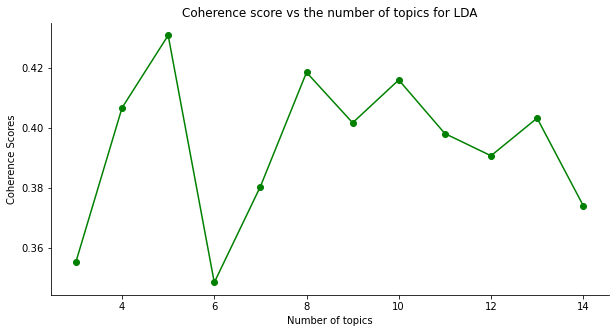

Becuase of the highest coherence the optimum number of topics are:  5


In [106]:
selected_topics = np.argmax(scores)+3

plt.figure(figsize=(10, 5))
plt.plot(list(range(3,15)), scores, marker='o', color='green')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.locator_params(integer=True)
plt.title('Coherence score vs the number of topics for LDA')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('lda_scores.jpg')
plt.show()

print('Becuase of the highest coherence the optimum number of topics are: ', selected_topics)

In [107]:
#chosen number of topic = 4 as the intertopic distance map shows a better result than 5 topics (topic 1 and 5 are relatively close tgt which means they're similar)
import pyLDAvis.gensim_models

selected_topics=4
lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dct, num_topics=selected_topics,\
                                           random_state=12, chunksize=128, passes=10 )

pyLDAvis.enable_notebook()
results = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dct, sort_topics=False)
pyLDAvis.save_html(results, 'ldavis_english' +'.html')
results

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.056231  0.007372       1        1   5.520259
1      0.073985 -0.029857       2        1   6.936783
2      0.062947  0.023965       3        1   6.149383
3     -0.193162 -0.001480       4        1  81.393575, topic_info=          Term        Freq       Total Category  logprob  loglift
1848    costco    6.000000    6.000000  Default  30.0000  30.0000
588      price  124.000000  124.000000  Default  29.0000  29.0000
1834     olive    4.000000    4.000000  Default  28.0000  28.0000
159    cooking    4.000000    4.000000  Default  27.0000  27.0000
2568    noodle    4.000000    4.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
64    purchase   38.374749   38.704569   Topic4  -5.9297   0.1973
77       would   37.450968   37.780658   Topic4  -5.9541   0.1971
116      cheap   37.671811   38.005396   Topic4  -5.9482   0.1971
7         food   36.635319   36.964941   Topic4  -5.9761   0.1969
37         can   36.097133   36.428761   Topic4  -5.9909   0.1967

[169 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4054      3  0.690987        -this
4817      3  0.472372  adventurous
4817      4  0.472372  adventurous
1910      2  0.874534   affordable
209       4  0.994813       amazon
...     ...       ...          ...
1399      2  0.978221    wholesome
3103      2  0.983442  wonderfully
77        4  0.979337        would
8325      1  0.951594       yorkie
8320      1  0.850035     yosemite

[151 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [108]:
top_words_df = pd.DataFrame()
for k in range(selected_topics):
  # top words with it's weight for a given id k 
  top_words = lda_model.show_topic(topicid=k)
  
  # only keep the word and discard the weight
  top_words_df['Topic {}'.format(k)] = [pair[0] for pair in top_words]
top_words_df

,Topic 0,Topic 1,Topic 2,Topic 3
0,ginger,costco,olive,price
1,timely,ridiculous,cooking,great
2,school,loose,noodle,good
3,petsmart,previous,pasta,buy
4,manner,affordable,steak,find
5,chai,licorice,skin,store
6,florida,harder,hurry,love
7,match,impossible,tuna,product
8,anxious,wholesome,moisturizer,amazon
9,bear,wonderfully,moo,get


In [109]:
predicted_topics = lda_model[corpus_tfidf]

# Extract the predicted topic for each document
predicted_topics = [max(prob, key=lambda x: x[1])[0] for prob in predicted_topics]


# Append the predicted topics to the DataFrame
df_positive['Topics'] = predicted_topics
df_positive['Topics'].unique()

/var/folders/ht/cj1ls1bj3s549x8c5ymchh2r0000gn/T/ipykernel_67069/2463061490.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive['Topics'] = predicted_topics


array([3, 2, 1, 0])

# LDA for negative

In [111]:
df_negative.head()

,Unnamed: 0,Sentiment,Time,cleaned,Text
44,44,negative,10/3/21,"['stuff', 'take', 'finish', 'basically', 'pres...",something to eat if you're starving - but plea...
62,62,negative,25/4/21,"['sale', 'chicken', 'throughout', 'buy', 'comp...",i ordered a flat of food (they were on sale) t...
70,70,negative,28/9/21,"['grape', 'particularly', 'quite', 'pomegranat...","unlike another product i reviewed for vine, at..."
76,76,negative,25/5/21,"['alone', 'gimme', 'size', 'kind', 'genuine', ...",gimme better ingredients (kind/larabars) for m...
93,93,negative,3/6/21,"['google', 'dogswell', 'safe', 'eat', 'happy',...",do not fed your dog any happy hip = dogswell p...


In [112]:
tokens = []
for sentence in df_negative['cleaned']:
    tokens.append(ast.literal_eval(sentence))

len(tokens)

# including bigrams as tokens 
sents = [bigram_mod[token] for token in tokens]

# Create Dictionary to keep track of vocab
dct = corpora.Dictionary(tokens)

print('Unique words before filtering/after pre-processing', len(dct))

# Create Corpus(Database)
corpus = [dct.doc2bow(sent) for sent in sents]

tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]



Unique words before filtering/after pre-processing 6592


3 0.40311109681128193
4 0.40759950948842844
5 0.4154874057852701
6 0.3923397662487154
7 0.4000904325775257
8 0.3968686293860405
9 0.40449149555581465
10 0.3929205214225029
11 0.4077315910322087
12 0.4018966401437993
13 0.3658446166303413
14 0.3756409938124247


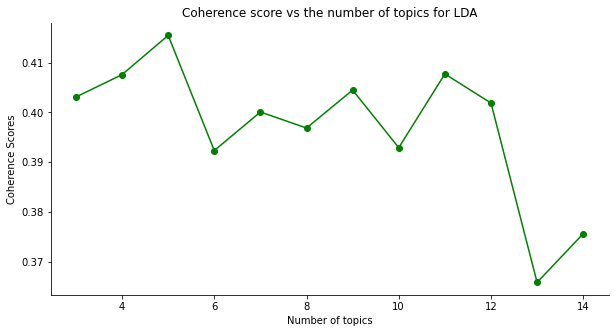

Becuase of the highest coherence the optimum number of topics are:  5


In [113]:
#randomstate = 12
scores = []
for k in range(3,15):
    # LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, num_topics=k, 
                                                 id2word=dct, random_state=12)
    # to calculate score for coherence
    coherence_model_lda = CoherenceModel(model=lda_model, texts=sents, dictionary=dct, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(k, coherence_lda)
    scores.append(coherence_lda)

selected_topics = np.argmax(scores)+3

plt.figure(figsize=(10, 5))
plt.plot(list(range(3,15)), scores, marker='o', color='green')
sns.despine(top=True, right=True, left=False, bottom=False)

plt.locator_params(integer=True)
plt.title('Coherence score vs the number of topics for LDA')
plt.xlabel('Number of topics')
plt.ylabel('Coherence Scores')
plt.savefig('lda_scores.jpg')
plt.show()

print('Becuase of the highest coherence the optimum number of topics are: ', selected_topics)



In [114]:
#chosen number of topic = 4 for negative sentiments
import pyLDAvis.gensim_models

selected_topics=4
lda_model = gensim.models.LdaModel(corpus=corpus_tfidf, id2word=dct, num_topics=selected_topics,\
                                           random_state=12, chunksize=128, passes=10 )

pyLDAvis.enable_notebook()
results = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dct, sort_topics=False)
pyLDAvis.save_html(results, 'ldavis_english' +'.html')
results

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.057122  0.025609       1        1   4.727739
1      0.038885 -0.024031       2        1   4.329193
2      0.030715 -0.004626       3        1   4.427285
3     -0.126722  0.003048       4        1  86.515783, topic_info=             Term       Freq      Total Category  logprob  loglift
6591       tropic   4.000000   4.000000  Default  30.0000  30.0000
4711     hawaiian   4.000000   4.000000  Default  29.0000  29.0000
4806      paragon   4.000000   4.000000  Default  28.0000  28.0000
188   concentrate   3.000000   3.000000  Default  27.0000  27.0000
2825   supplement   3.000000   3.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
889        reason  14.838329  14.972741   Topic4  -6.0235   0.1358
75           them  14.672346  14.806368   Topic4  -6.0348   0.1358
40           long  14.660234  14.794609   Topic4  -6.0356   0.1357
2197   purchasing  14.553591  14.688782   Topic4  -6.0429   0.1356
1491       simply  15.105525  15.280427   Topic4  -6.0057   0.1333

[164 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
87        4  0.977633       again
1         4  0.972787         all
6297      4  1.391105  b0040pyn86
922       4  0.972306       begin
97        4  1.006881         buy
...     ...       ...         ...
6589      1  0.594899  unsuitable
1986      1  0.669239     utterly
1899      1  0.641210      walked
2124      4  0.938863        wind
165       4  1.020580       would

[84 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [116]:
top_words_df = pd.DataFrame()
for k in range(selected_topics):
  # top words with it's weight for a given id k 
  top_words = lda_model.show_topic(topicid=k)
  
  # only keep the word and discard the weight
  top_words_df['Topic {}'.format(k+4)] = [pair[0] for pair in top_words]
top_words_df


,Topic 4,Topic 5,Topic 6,Topic 7
0,rear,tropic,holder,thank
1,recourse,hawaiian,amozon,again
2,degraded,paragon,works,item
3,disclaimer,concentrate,hire,cheese
4,enjoyment,maui,instructions,purchase
5,inexcusable,carry,interpreter,product
6,intolerably,pleasant,envelop,all
7,junky,wast,office,taste
8,llike,syrup,build,lately
9,pre-purchase,roaster,cupboard,flavor


In [130]:
predicted_topics = lda_model[corpus_tfidf]

# Extract the predicted topic for each document
predicted_topics = [(max(prob, key=lambda x: x[1])[0] + 4) for prob in predicted_topics]


# Append the predicted topics to the DataFrame
df_negative['Topics'] = predicted_topics
df_negative['Topics'].unique()

/var/folders/ht/cj1ls1bj3s549x8c5ymchh2r0000gn/T/ipykernel_67069/121665238.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_negative['Topics'] = predicted_topics


array([7, 4, 6, 5])

In [131]:
#combine the positive and negative dataset
df_result = pd.concat([df_positive, df_negative])

In [132]:
df_result
#df_result.to_csv('/Users/charlenechan/Desktop/y4s2/DSA4263/project/topic_whole_data.csv')